###  graph mlab metrics for TWC vs Level 3

Looking at Implications that Time Warner Cable was manipulating provisioning to Level 3 to force them and Netflix to pay higher rates. They also were under pressure to keep net performance up by FCC, but that was only measured during the network sweeps months: Feb, May, July, Nov. If true, then should see step-like changes to performance for TWC vs Level3, but not TWC vs other transit ISPs not used by Netflix.

In this example, I am plotting ALL mlab tests in the US involving TWC and Level 3 throughout 2014

TLDR: the plot shows no obvious difference in any metric between sweeps months and non-sweeps months.

Created by John Burt, for allTBD group.


In [22]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

# set matplotlib environment and import some basics
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
#matplotlib.style.use('classic')
plt.rcParams.update({'font.size':15}) # set default font size, otherwise it is too small on my pc

import pandas as pd
import numpy as np
import datetime
import calendar
import pickle

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100 # set to -1 to see entire text

# load the prepared mlab data. 
def get_data(datafilename):
    # data is a dict of dataframes keyd by city name
    with open(datafilename, 'rb') as handle:
        df = pickle.load(handle)
        
    df["time"] = pd.to_datetime(df.log_time,unit='s')
    df = df.sort_values("time")
    # get records that have these area codes
    return df

# this data was generated from an mlab query by the notebook m-lab_state_query_v1.ipynb
df = get_data('mlab_data_mlabnetdb_2014-2015_all_states.pkl')


In [23]:
# this section is needed on my laptop to get reasonable font sizes in plots:

# set all font sizes
matplotlib.rcParams.update({'font.size': 18})

# set all line widths
matplotlib.rcParams.update({'lines.linewidth': 3})

# set all symbol sizes
matplotlib.rcParams.update({'lines.markersize': 10})

matplotlib.rcParams.update({'axes.facecolor': 'white'})
matplotlib.rcParams.update({'axes.edgecolor': 'black'})


In [24]:
def windowed_stats_by_hour(time, y, windowhours=24):
    timeout = []
    y_n = []
    y_mean = []
    y_median = []
    y_std = []
    
    starthour = time.min()
    samples = []
    for i in range(len(y)):
        dif = (time[i] - starthour)/np.timedelta64(1, 'h')
        
        if dif < windowhours:
            samples.append(y[i])
        else:
            if (len(samples)):
                timeout.append(starthour)
                y_n.append(len(samples))
                y_mean.append(np.mean(samples))
                y_median.append(np.median(samples))
                y_std.append(np.std(samples))
            starthour += np.timedelta64(windowhours, 'h')
            samples = []

    if len(samples):
        if (len(samples)):
            timeout.append(starthour)
            y_n.append(len(samples))
            y_mean.append(np.mean(samples))
            y_median.append(np.median(samples))
            y_std.append(np.std(samples))

    return timeout, y_n, y_mean, y_median, y_std


In [25]:
def plot_data(ax, x, y, y_n, y_std, 
                    label='ISP', title='Internet throughput', plot_SE=True,
                    markersize=5, color='b', ylabel=''):
    plt.title(title);
    if plot_SE:
        se = y_std/np.sqrt(y_n)
        ax.errorbar(x ,y, yerr=se, fmt=color+'-', label=label, markersize=5)
#        ax.errorbar(x ,y, yerr=se, fmt=None, label=label, markersize=5)
    else:
        ax.plot(x ,y, color+'-', label=label, markersize=5)
        
    # plot the sweeps months
    year = min(x).astype('M8[D]').astype('O').year

    # Feb, May, July, Nov
    ax.hlines(y=0, xmin=datetime.datetime(year, 2, 1), 
                    xmax=datetime.datetime(year, 3, 1), 
                    color='m',linewidth=10, label='Sweeps month')
    ax.hlines(y=0, xmin=datetime.datetime(year, 5, 1), 
                    xmax=datetime.datetime(year, 6, 1), 
                    color='m',linewidth=10)
    ax.hlines(y=0, xmin=datetime.datetime(year, 7, 1), 
                    xmax=datetime.datetime(year, 8, 1), 
                    color='m',linewidth=10)
    ax.hlines(y=0, xmin=datetime.datetime(year, 11, 1), 
                    xmax=datetime.datetime(year, 12, 1), 
                    color='m',linewidth=10)
    plt.legend(loc="upper left")
    plt.ylabel(ylabel)
    
    

In [26]:
# create df with all TWC records
TWCdf = df.groupby("access_ISP_name").get_group("Time Warner Cable")


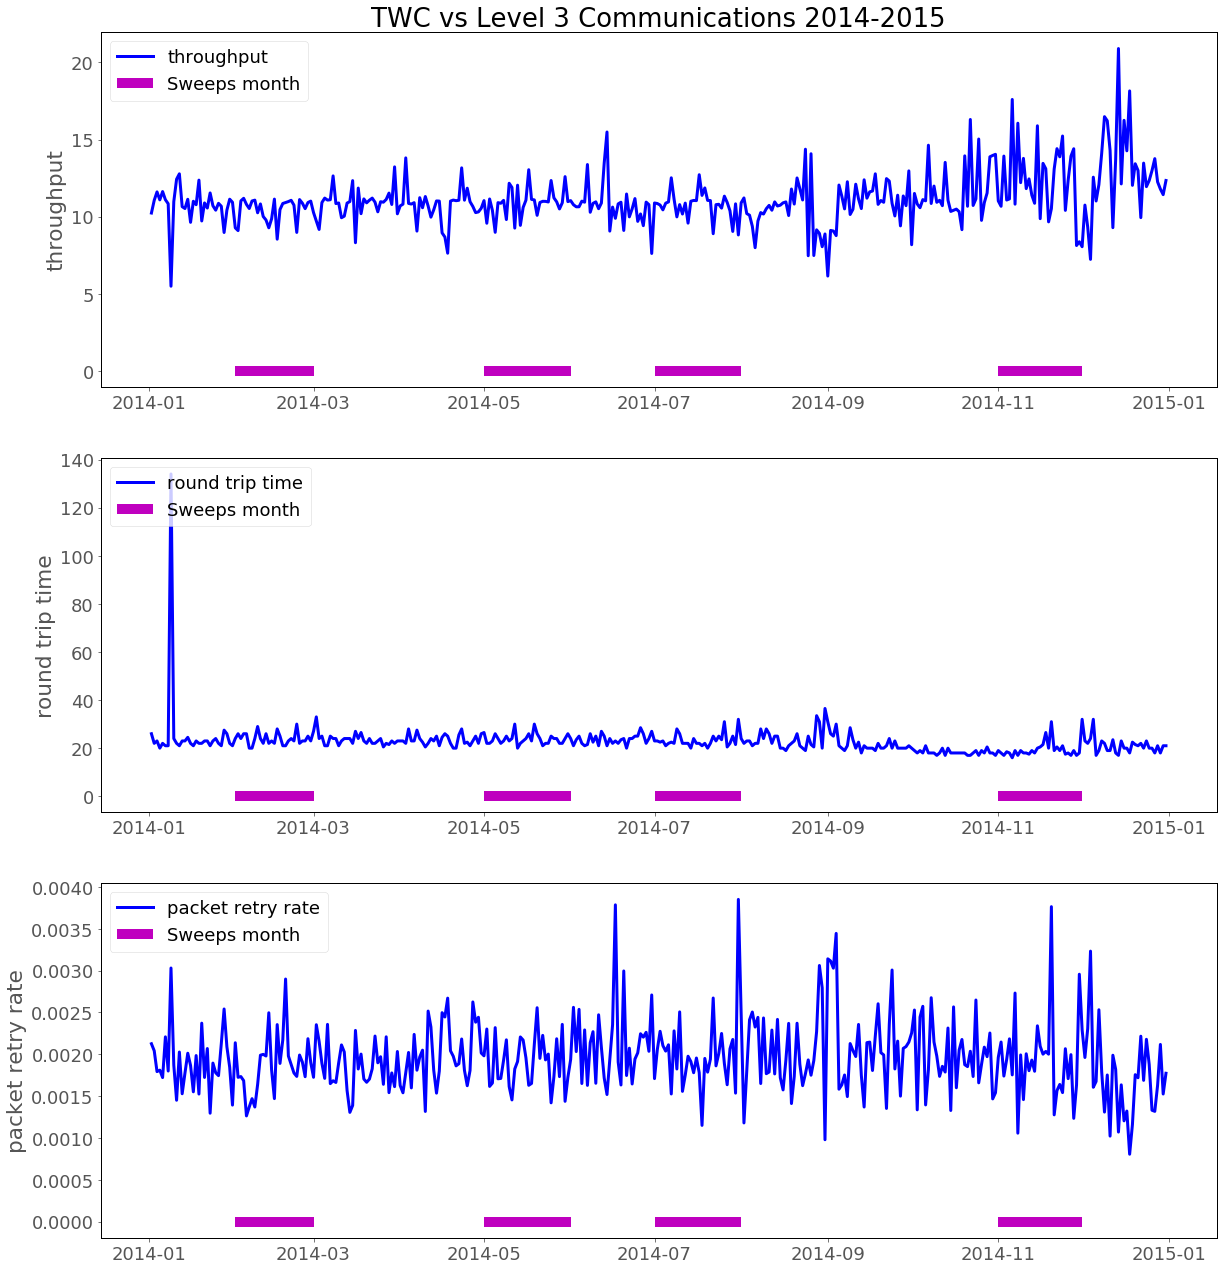

In [28]:
# names of transit ISPs to plot
tISPnames = ([
#     "Cogent Communications",
    "Level 3 Communications",
#     "Tata Communications (america)",
#     "Zayo Bandwidth"
])

# window hours to combine data for plot stats
windowhrs = 24

# start and end dates to plot
startdate = datetime.datetime(2014, 1, 1)
enddate = datetime.datetime(2015, 1, 1)

col=['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure(figsize=(20,30*len(tISPnames)), facecolor='w', edgecolor='k')
i=0
for tispname in tISPnames:
    # create df containing this transit ISP's data
    ispdf = TWCdf.groupby("transit_ISP_name").get_group(tispname)
    ispdf = ispdf[(ispdf.time>=startdate) & (ispdf.time<=enddate)]
    
    # plot throughput
    x, y_n, y_mean, y_median, y_std = windowed_stats_by_hour(ispdf.time.values, 
                                            ispdf.download_Mbps.values, windowhrs)
#     print(tispname, "dtp",ispdf.shape[0],len(x))
    ax = plt.subplot(len(tISPnames)*4,1,i*4+1)
    title = "TWC vs %s %d-%d"%(tispname,startdate.year,enddate.year)
    ylabel = 'throughput'
    plot_data(ax, x, y_median, y_n, y_std, 
                        label=ylabel, title=title, ylabel=ylabel,
                        plot_SE=False,
                        markersize=5, color=col[i])

    # plot round trip time
    x, y_n, y_mean, y_median, y_std = moving_median_by_hour(ispdf.time.values, 
                                            ispdf.min_rtt.values, windowhrs)
#     print(tispname, "rtt",ispdf.shape[0],len(x))
    ax = plt.subplot(len(tISPnames)*4,1,i*4+2)
    title = ""
    ylabel = 'round trip time'
    plot_data(ax, x, y_median, y_n, y_std, 
                        label=ylabel, title=title, ylabel=ylabel,
                        plot_SE=False,
                        markersize=5, color=col[i])
#     plt.ylim((0, 40))

    # plot packet retry rate
    x, y_n, y_mean, y_median, y_std = moving_median_by_hour(ispdf.time.values, 
                                            ispdf.packet_retransmission_rate.values, windowhrs)
#     print(tispname, "prt",ispdf.shape[0],len(x))
    ax = plt.subplot(len(tISPnames)*4,1,i*4+3)
    title = ""
    ylabel = 'packet retry rate'
    plot_data(ax, x, y_median, y_n, y_std, 
                        label=ylabel, title=title, ylabel=ylabel,
                        plot_SE=False,
                        markersize=5, color=col[i])
#     plt.ylim((0, .006))
    
    i+=1

